### Import Libraries

In [2]:
# !pip install efficientnet_pytorch
!pip install -q catalyst
!pip install -q albumentations
!pip install -q efficientnet_pytorch

In [3]:
import os
import cv2
import time
import json
# from PIL import Image 
import datetime
from pathlib import Path

import warnings
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.datasets as datasets

from efficientnet_pytorch import EfficientNet

import albumentations as A
from albumentations.pytorch import ToTensorV2

from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.sampler import SequentialSampler

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore",category=UserWarning)
SEED=42
%matplotlib inline


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchamrk=True

In [5]:
df=pd.read_csv("/kaggle/input/cassava-leaf-disease-classification/train.csv")
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

### Model

In [7]:
def Net(model_name='b0',output=5):
    model=EfficientNet.from_pretrained(f'efficientnet-{model_name}')
    model._fc=nn.Linear(in_features=model._fc.in_features,
                        out_features=output,bias=True)
    return model                    

In [ ]:
Net()

### DataLoader

In [9]:

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, labels, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        # print(image_id.dtype)
        image = cv2.imread(f"/kaggle/input/cassava-leaf-disease-classification/train_images/{image_id}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.labels[idx]

        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
#         print("datalaoder hello")    
        return image, label

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):

        return list(self.labels)


### Augumentations

In [10]:
def train_augmentations(img_size=512):
    return A.Compose([
        A.Resize(height=img_size, width=img_size, p=1),
        A.RandomSizedCrop(min_max_height=(int(img_size-0.2*img_size), int(img_size-0.2*img_size)),
                          height=img_size, width=img_size, p=0.5),  
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.CoarseDropout(max_holes=8, max_width=12,
                        max_height=12, fill_value=0, p=0.5),
        ToTensorV2(p=1.0),
    ], p=1.0)


def validation_augumentations(img_size=512):
    return A.Compose([
        A.Resize(height=img_size, width=img_size, p=1.0),
        ToTensorV2(p=1.0),
    ], p=1.0)


3


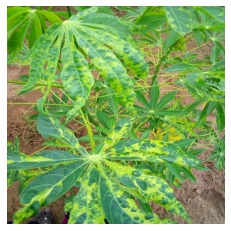

In [11]:
obj=DatasetRetriever(df.image_id.values,df.label.values,validation_augumentations())
images,labels=obj[9543]
plt.imshow(images.numpy().transpose(1,2,0))
plt.axis('off')
print(labels)

### Configuration

In [12]:
class Config:
    output=5
    num_workers=4
    batch_size=32

    img_size=224
    n_epochs=200
    lr=0.0003
    patience=5

    SchedulerClass=torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params=dict(
        mode='min',
        factor=0.8,
        patience=1,
        verbose=True,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )

### Train Model

In [13]:
train_loss=dict()
valid_loss=dict()

class Train:
    
    def __init__(self,model,device,config,fold,model_name='b0',image_size=384, weight_path='./'):
  
        self.model=model
        self.device=device
        self.config=config
        self.best_score=0
        self.best_loss=5000
        self.fold=fold
        self.model_name = model_name
        self.image_size = image_size
        self.weight_path = weight_path
        

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        
    def fit(self,train_loader,validation_loader):
        for epoch in range(self.config.n_epochs):

            print("Training Started...")
            t=time.time()
            Loss = self.train_one_epoch(train_loader)
            train_loss[epoch] = Loss.avg

            print(f'Train : Epoch {epoch}: | Loss: {Loss.avg} | Training time: {time.time()-t}')
            
            t=time.time()
            print("Validation Started...")
            loss = self.validation(validation_loader)
            valid_loss[epoch] = Loss.avg

            print(f'Valid : Epoch {epoch}: | Loss: {Loss.avg} | Training time: {time.time()-t}')
            
            self.scheduler.step(metrics=Loss.avg)
            
            if not self.best_score:
                self.best_score = Loss.avg  # So any validation roc_auc we have is the best one for now
                print(f'Saving model with best val as {self.best_score}')
                self.model.eval()   
                patience = self.config.patience
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
                continue  

            if Loss.avg <= self.best_score:
                self.best_score = Loss.avg
                patience = self.config.patience  # Resetting patience since we have new best validation accuracy
                print(f'Improved model with best val as {self.best_score}')
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
            else:
                patience -= 1
                print('Patience Reduced')
                if patience == 0:
                    print(f'Early stopping. Best Val: {self.best_score}')
                    break
                    
    def validation(self, val_loader):
        self.model.eval()
        Loss = AverageMeter()

        t = time.time()

        for steps,(images, targets) in enumerate(tqdm(val_loader)):
            with torch.no_grad():
                targets = targets.to(self.device, dtype=torch.long)
                batch_size = images.shape[0]               
                images = images.to(self.device, dtype=torch.float32)
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

                Loss.update(loss.detach().item(), batch_size)

        return Loss


    def train_one_epoch(self, train_loader):
        self.model.train()

        Loss = AverageMeter()

        t = time.time()

#         print("hello before vala")
        for steps,(images, targets) in enumerate(tqdm(train_loader)):
#             print("hello after ")
            targets = targets.to(self.device, dtype=torch.long)
            batch_size = images.shape[0]               
            images = images.to(self.device, dtype=torch.float32)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            Loss.update(loss.detach().item(), batch_size)

        return Loss
                           

In [14]:
#this is just a good practice of calcualting and storing the values. Not a compulsion. Check ImageNet code from pytorch examples for more info
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


### spliting

In [15]:
base_dir = Path('/kaggle/input/cassava-leaf-disease-classification/')
train_df = pd.read_csv(f'{base_dir}/train.csv')
with open(f'{base_dir}/label_num_to_disease_map.json') as f:
    class_names = json.loads(f.read())
f.close()


In [16]:
class_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [17]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [18]:
train_df['label_name'] = train_df['label'].apply(lambda x: class_names[str(x)])
train_df.head()

,image_id,label,label_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [19]:
sk = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
for fold, (train, val) in enumerate(sk.split(train_df, train_df.label)):
    train_df.loc[val, 'fold'] = fold
train_df.fold = train_df.fold.astype(int)
train_df.fold.value_counts()

0    5350
2    5349
1    5349
3    5349
Name: fold, dtype: int64

### Validation

In [22]:
def test(fold_number=0,model_name='b3',image_size=512,weight_path='./',load_weights_path=None):
    train_X = train_df[train_df['fold'] != fold_number].image_id.values
    train_Y = train_df[train_df['fold'] != fold_number].label.values
    valid_X = train_df[train_df['fold'] == fold_number].image_id.values
    valid_Y = train_df[train_df['fold'] == fold_number].label.values

    train_dataset=DatasetRetriever(train_X,train_Y,train_augmentations(img_size=image_size))
    valid_dataset=DatasetRetriever(valid_X,valid_Y,validation_augumentations(img_size=image_size))

    train_loader=torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(),mode='downsampling'),
        batch_size=Config.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=Config.num_workers,
    )
    validation_loader=torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=Config.batch_size,
        num_workers=Config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=False,
    )
    model=Net(model_name=model_name).cuda()
    if load_weights_path is not None:
        model.load_state_dict(torch.load(load_weights_path + f"{image_size} {model_name}_{fold_number}.pt")["model_state_dict"])
        print("Weight Loaded")
    engine = Train(model=model, device=torch.device('cuda'), config=Config, fold=fold_number,
    model_name=model_name, image_size=image_size, weight_path=weight_path)
    engine.fit(train_loader, validation_loader)

In [23]:
test(fold_number=0, model_name='b3', image_size=224)
# #

Loaded pretrained weights for efficientnet-b3
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 0: | Loss: 1.134340317699853 | Training time: 45.74572801589966
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 0: | Loss: 1.134340317699853 | Training time: 39.27714920043945
Saving model with best val as 1.134340317699853
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 1: | Loss: 0.8592096438088755 | Training time: 46.119534730911255
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 1: | Loss: 0.8592096438088755 | Training time: 38.39711809158325
Imporved model with best val as 0.8592096438088755
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 2: | Loss: 0.7676091299751612 | Training time: 46.12626123428345
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 2: | Loss: 0.7676091299751612 | Training time: 38.88092660903931
Imporved model with best val as 0.7676091299751612
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 3: | Loss: 0.7318947735264545 | Training time: 45.772523164749146
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 3: | Loss: 0.7318947735264545 | Training time: 39.02069854736328
Imporved model with best val as 0.7318947735264545
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 4: | Loss: 0.6524840260115196 | Training time: 45.531251668930054
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 4: | Loss: 0.6524840260115196 | Training time: 38.67584943771362
Imporved model with best val as 0.6524840260115196
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 5: | Loss: 0.6260524436714142 | Training time: 45.41519784927368
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 5: | Loss: 0.6260524436714142 | Training time: 38.73416185379028
Imporved model with best val as 0.6260524436714142
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 6: | Loss: 0.5972375636260341 | Training time: 45.71596693992615
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 6: | Loss: 0.5972375636260341 | Training time: 38.89277172088623
Imporved model with best val as 0.5972375636260341
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 7: | Loss: 0.5820480390327183 | Training time: 46.33582043647766
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 7: | Loss: 0.5820480390327183 | Training time: 38.96607804298401
Imporved model with best val as 0.5820480390327183
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 8: | Loss: 0.5348314134858725 | Training time: 46.05947256088257
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 8: | Loss: 0.5348314134858725 | Training time: 39.44705891609192
Imporved model with best val as 0.5348314134858725
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 9: | Loss: 0.5133324048415883 | Training time: 46.075467348098755
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 9: | Loss: 0.5133324048415883 | Training time: 38.966936349868774
Imporved model with best val as 0.5133324048415883
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 10: | Loss: 0.5103337479623284 | Training time: 46.02375030517578
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 10: | Loss: 0.5103337479623284 | Training time: 38.5558602809906
Imporved model with best val as 0.5103337479623284
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 11: | Loss: 0.46834525548097655 | Training time: 45.33912253379822
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 11: | Loss: 0.46834525548097655 | Training time: 38.90923190116882
Imporved model with best val as 0.46834525548097655
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 12: | Loss: 0.442172709999122 | Training time: 45.35638189315796
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 12: | Loss: 0.442172709999122 | Training time: 39.08450198173523
Imporved model with best val as 0.442172709999122
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 13: | Loss: 0.452590865295703 | Training time: 45.61325287818909
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 13: | Loss: 0.452590865295703 | Training time: 38.57655334472656
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 14: | Loss: 0.42989953243591655 | Training time: 45.22211503982544
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 14: | Loss: 0.42989953243591655 | Training time: 38.241424798965454
Imporved model with best val as 0.42989953243591655
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 15: | Loss: 0.41473256315537327 | Training time: 45.938152551651
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 15: | Loss: 0.41473256315537327 | Training time: 38.73380184173584
Imporved model with best val as 0.41473256315537327
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 16: | Loss: 0.38430783252312445 | Training time: 45.35162830352783
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 16: | Loss: 0.38430783252312445 | Training time: 39.37386202812195
Imporved model with best val as 0.38430783252312445
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 17: | Loss: 0.3841964269247581 | Training time: 45.30620336532593
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 17: | Loss: 0.3841964269247581 | Training time: 38.5113742351532
Imporved model with best val as 0.3841964269247581
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 18: | Loss: 0.35871390511435786 | Training time: 45.810800313949585
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 18: | Loss: 0.35871390511435786 | Training time: 38.63947248458862
Imporved model with best val as 0.35871390511435786
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 19: | Loss: 0.3594548680533574 | Training time: 45.304771900177
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 19: | Loss: 0.3594548680533574 | Training time: 38.70662188529968
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 20: | Loss: 0.338984595391694 | Training time: 45.777177810668945
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 20: | Loss: 0.338984595391694 | Training time: 38.28872561454773
Imporved model with best val as 0.338984595391694
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 21: | Loss: 0.3198773638000639 | Training time: 45.45812463760376
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 21: | Loss: 0.3198773638000639 | Training time: 39.38906121253967
Imporved model with best val as 0.3198773638000639
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 22: | Loss: 0.31234216643130686 | Training time: 46.318631649017334
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 22: | Loss: 0.31234216643130686 | Training time: 39.23541235923767
Imporved model with best val as 0.31234216643130686
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 23: | Loss: 0.32455744224739824 | Training time: 45.83876442909241
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 23: | Loss: 0.32455744224739824 | Training time: 38.32015562057495
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 24: | Loss: 0.3331923150699439 | Training time: 45.421794414520264
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 24: | Loss: 0.3331923150699439 | Training time: 38.683802127838135
Epoch    25: reducing learning rate of group 0 to 2.4000e-04.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 25: | Loss: 0.288686268852921 | Training time: 45.732930183410645
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 25: | Loss: 0.288686268852921 | Training time: 38.63107514381409
Imporved model with best val as 0.288686268852921
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 26: | Loss: 0.2371604933924093 | Training time: 45.1436722278595
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 26: | Loss: 0.2371604933924093 | Training time: 39.043519735336304
Imporved model with best val as 0.2371604933924093
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 27: | Loss: 0.2665125976397297 | Training time: 45.43602228164673
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 27: | Loss: 0.2665125976397297 | Training time: 38.80192303657532
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 28: | Loss: 0.25746886660968227 | Training time: 45.80159068107605
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 28: | Loss: 0.25746886660968227 | Training time: 39.02642631530762
Epoch    29: reducing learning rate of group 0 to 1.9200e-04.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 29: | Loss: 0.21011753826160132 | Training time: 45.48953151702881
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 29: | Loss: 0.21011753826160132 | Training time: 38.59386920928955
Imporved model with best val as 0.21011753826160132
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 30: | Loss: 0.20864085524570286 | Training time: 45.961899757385254
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 30: | Loss: 0.20864085524570286 | Training time: 38.41062140464783
Imporved model with best val as 0.20864085524570286
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 31: | Loss: 0.19281086262579508 | Training time: 45.28558373451233
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 31: | Loss: 0.19281086262579508 | Training time: 39.612877368927
Imporved model with best val as 0.19281086262579508
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 32: | Loss: 0.18804032977406435 | Training time: 45.566877603530884
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 32: | Loss: 0.18804032977406435 | Training time: 38.671146631240845
Imporved model with best val as 0.18804032977406435
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 33: | Loss: 0.1717073243316703 | Training time: 45.883408069610596
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 33: | Loss: 0.1717073243316703 | Training time: 39.06903886795044
Imporved model with best val as 0.1717073243316703
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 34: | Loss: 0.15787687434220876 | Training time: 45.648560762405396
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 34: | Loss: 0.15787687434220876 | Training time: 38.71299457550049
Imporved model with best val as 0.15787687434220876
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 35: | Loss: 0.1821101835422863 | Training time: 45.96097135543823
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 35: | Loss: 0.1821101835422863 | Training time: 38.90442967414856
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 36: | Loss: 0.16897401311911467 | Training time: 45.39374279975891
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 36: | Loss: 0.16897401311911467 | Training time: 39.324230432510376
Epoch    37: reducing learning rate of group 0 to 1.5360e-04.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 37: | Loss: 0.159029544969126 | Training time: 45.6557457447052
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 37: | Loss: 0.159029544969126 | Training time: 38.65617775917053
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 38: | Loss: 0.13868796045151283 | Training time: 45.83198380470276
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 38: | Loss: 0.13868796045151283 | Training time: 38.728487730026245
Imporved model with best val as 0.13868796045151283
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 39: | Loss: 0.13739437080450415 | Training time: 45.37668228149414
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 39: | Loss: 0.13739437080450415 | Training time: 39.07020401954651
Imporved model with best val as 0.13739437080450415
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 40: | Loss: 0.15023539781453102 | Training time: 45.62391901016235
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 40: | Loss: 0.15023539781453102 | Training time: 38.56743407249451
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 41: | Loss: 0.13242546095710805 | Training time: 46.00276565551758
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 41: | Loss: 0.13242546095710805 | Training time: 38.939000844955444
Imporved model with best val as 0.13242546095710805
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 42: | Loss: 0.14099530412954844 | Training time: 45.39425587654114
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 42: | Loss: 0.14099530412954844 | Training time: 38.586519956588745
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 43: | Loss: 0.10951069154314638 | Training time: 46.241710901260376
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 43: | Loss: 0.10951069154314638 | Training time: 38.96763825416565
Imporved model with best val as 0.10951069154314638
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 44: | Loss: 0.11795938232781615 | Training time: 45.65708899497986
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 44: | Loss: 0.11795938232781615 | Training time: 38.96885442733765
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 45: | Loss: 0.11943053739424062 | Training time: 45.17169690132141
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 45: | Loss: 0.11943053739424062 | Training time: 38.69698619842529
Epoch    46: reducing learning rate of group 0 to 1.2288e-04.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 46: | Loss: 0.10787829885068606 | Training time: 45.798657178878784
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 46: | Loss: 0.10787829885068606 | Training time: 38.65144729614258
Imporved model with best val as 0.10787829885068606
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 47: | Loss: 0.11077679945962636 | Training time: 45.679725885391235
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 47: | Loss: 0.11077679945962636 | Training time: 39.444923400878906
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 48: | Loss: 0.09755475865310337 | Training time: 45.374316453933716
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 48: | Loss: 0.09755475865310337 | Training time: 39.107619524002075
Imporved model with best val as 0.09755475865310337
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 49: | Loss: 0.1051895192230311 | Training time: 45.57723665237427
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 49: | Loss: 0.1051895192230311 | Training time: 38.588643074035645
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 50: | Loss: 0.09918240565571963 | Training time: 45.34806227684021
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 50: | Loss: 0.09918240565571963 | Training time: 39.61534667015076
Epoch    51: reducing learning rate of group 0 to 9.8304e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 51: | Loss: 0.10262123589205929 | Training time: 45.803380727767944
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 51: | Loss: 0.10262123589205929 | Training time: 38.632776498794556
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 52: | Loss: 0.08748495757330473 | Training time: 46.134560108184814
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 52: | Loss: 0.08748495757330473 | Training time: 38.501396894454956
Imporved model with best val as 0.08748495757330473
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 53: | Loss: 0.08518583052168328 | Training time: 45.76590967178345
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 53: | Loss: 0.08518583052168328 | Training time: 38.859472036361694
Imporved model with best val as 0.08518583052168328
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 54: | Loss: 0.08298080598964817 | Training time: 46.00818228721619
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 54: | Loss: 0.08298080598964817 | Training time: 38.85556650161743
Imporved model with best val as 0.08298080598964817
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 55: | Loss: 0.07958234801125808 | Training time: 45.235352993011475
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 55: | Loss: 0.07958234801125808 | Training time: 39.046056032180786
Imporved model with best val as 0.07958234801125808
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 56: | Loss: 0.07839274566114594 | Training time: 45.30569672584534
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 56: | Loss: 0.07839274566114594 | Training time: 38.47903823852539
Imporved model with best val as 0.07839274566114594
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 57: | Loss: 0.07607348665125727 | Training time: 45.67154335975647
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 57: | Loss: 0.07607348665125727 | Training time: 40.83521223068237
Imporved model with best val as 0.07607348665125727
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 58: | Loss: 0.07899721461443568 | Training time: 45.871002435684204
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 58: | Loss: 0.07899721461443568 | Training time: 38.98997950553894
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 59: | Loss: 0.07641494060008544 | Training time: 45.59754920005798
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 59: | Loss: 0.07641494060008544 | Training time: 38.34442090988159
Epoch    60: reducing learning rate of group 0 to 7.8643e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 60: | Loss: 0.07773099189411527 | Training time: 45.568315744400024
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 60: | Loss: 0.07773099189411527 | Training time: 38.90439963340759
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 61: | Loss: 0.059862218546043115 | Training time: 45.309428453445435
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 61: | Loss: 0.059862218546043115 | Training time: 39.14426898956299
Imporved model with best val as 0.059862218546043115
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 62: | Loss: 0.059730110077671414 | Training time: 45.484662771224976
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 62: | Loss: 0.059730110077671414 | Training time: 38.58634924888611
Imporved model with best val as 0.059730110077671414
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 63: | Loss: 0.06680228843126358 | Training time: 45.366000175476074
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 63: | Loss: 0.06680228843126358 | Training time: 38.3730263710022
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 64: | Loss: 0.0728738010763814 | Training time: 45.649394035339355
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 64: | Loss: 0.0728738010763814 | Training time: 38.719850063323975
Epoch    65: reducing learning rate of group 0 to 6.2915e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 65: | Loss: 0.06756507945760322 | Training time: 45.14239311218262
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 65: | Loss: 0.06756507945760322 | Training time: 38.50260806083679
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 66: | Loss: 0.04844666829912036 | Training time: 45.988707542419434
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 66: | Loss: 0.04844666829912036 | Training time: 38.66510486602783
Imporved model with best val as 0.04844666829912036
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 67: | Loss: 0.05649299210113451 | Training time: 45.16635298728943
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 67: | Loss: 0.05649299210113451 | Training time: 39.3426992893219
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 68: | Loss: 0.05280405565304315 | Training time: 45.26423144340515
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 68: | Loss: 0.05280405565304315 | Training time: 38.32187223434448
Epoch    69: reducing learning rate of group 0 to 5.0332e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 69: | Loss: 0.04689030300396839 | Training time: 45.513086557388306
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 69: | Loss: 0.04689030300396839 | Training time: 39.16844725608826
Imporved model with best val as 0.04689030300396839
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 70: | Loss: 0.05187790272537413 | Training time: 45.417728900909424
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 70: | Loss: 0.05187790272537413 | Training time: 38.85272717475891
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 71: | Loss: 0.05468252406081581 | Training time: 45.87789249420166
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 71: | Loss: 0.05468252406081581 | Training time: 38.315032958984375
Epoch    72: reducing learning rate of group 0 to 4.0265e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 72: | Loss: 0.042910701971075785 | Training time: 45.497087478637695
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 72: | Loss: 0.042910701971075785 | Training time: 38.53839135169983
Imporved model with best val as 0.042910701971075785
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 73: | Loss: 0.04731269836733778 | Training time: 45.73917531967163
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 73: | Loss: 0.04731269836733778 | Training time: 38.44986891746521
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 74: | Loss: 0.04835742378999721 | Training time: 45.30659055709839
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 74: | Loss: 0.04835742378999721 | Training time: 38.693915128707886
Epoch    75: reducing learning rate of group 0 to 3.2212e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 75: | Loss: 0.036239077416835276 | Training time: 45.274840116500854
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 75: | Loss: 0.036239077416835276 | Training time: 38.500619649887085
Imporved model with best val as 0.036239077416835276
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 76: | Loss: 0.04479888024167928 | Training time: 45.414759397506714
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 76: | Loss: 0.04479888024167928 | Training time: 38.882426261901855
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 77: | Loss: 0.0380755244996252 | Training time: 45.36520075798035
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 77: | Loss: 0.0380755244996252 | Training time: 38.25772428512573
Epoch    78: reducing learning rate of group 0 to 2.5770e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 78: | Loss: 0.0425708416627544 | Training time: 45.754024505615234
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 78: | Loss: 0.0425708416627544 | Training time: 38.55263614654541
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 79: | Loss: 0.03783931891070899 | Training time: 45.336528301239014
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 79: | Loss: 0.03783931891070899 | Training time: 38.17546510696411
Epoch    80: reducing learning rate of group 0 to 2.0616e-05.
Patience Reduced
Training Started...


  0%|          | 0/127 [00:00<?, ?it/s]

Train : Epoch 80: | Loss: 0.03710223102252784 | Training time: 46.26349425315857
Validation Started...


  0%|          | 0/168 [00:00<?, ?it/s]

Valid : Epoch 80: | Loss: 0.03710223102252784 | Training time: 38.522984981536865
Patience Reduced
Early stopping. Best Val roc_auc: 0.036239077416835276


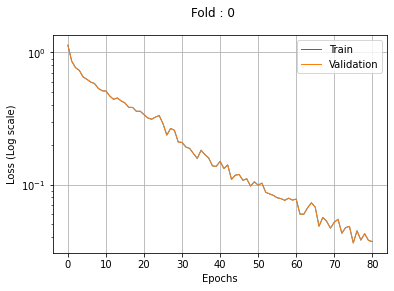

In [30]:
import matplotlib.pyplot as plt

plt.plot(list(train_loss.keys()), list(train_loss.values()), linewidth=1, label="Train")
plt.plot(list(valid_loss.keys()), list(valid_loss.values()),  linewidth=1, label="Validation")
plt.suptitle('Fold : 0 ')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log scale)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()